In [1]:
import sframe
import numpy as np
import pandas as pd
import string
from collections import Counter
import math

In [2]:
products = sframe.SFrame("amazon_baby_subset.gl/")

[INFO] sframe.cython.cy_server: SFrame v2.1 started. Logging /tmp/sframe_server_1503989138.log


In [3]:
products.head()

Columns:
	name	str
	review	str
	rating	float
	sentiment	int

Rows: 10

Data:
+-------------------------------+-------------------------------+--------+-----------+
|              name             |             review            | rating | sentiment |
+-------------------------------+-------------------------------+--------+-----------+
| Stop Pacifier Sucking with... | All of my kids have cried ... |  5.0   |     1     |
| Nature's Lullabies Second ... | We wanted to get something... |  5.0   |     1     |
| Nature's Lullabies Second ... | My daughter had her 1st ba... |  5.0   |     1     |
|  Lamaze Peekaboo, I Love You  | One of baby's first and fa... |  4.0   |     1     |
| SoftPlay Peek-A-Boo Where'... | Very cute interactive book... |  5.0   |     1     |
|   Our Baby Girl Memory Book   | Beautiful book, I love it ... |  5.0   |     1     |
| Hunnt&reg; Falling Flowers... | Try this out for a spring ... |  5.0   |     1     |
| Blessed By Pope Benedict X... | very nice Divine Mercy Pen... |  5.0   |     1     |
| Cloth Diaper Pins Stainles... | We bought the pins as my 6... |  4.0   |     1     |
| Cloth Diaper Pins Stainles... | It has been many years sin... |  5.0   |     1     |
+-------------------------------+-------------------------------+--------+-----------+
[10 rows x 4 columns]

### feature cleaning and engineering

In [4]:
important_words = pd.read_json("important_words.json")
important_words = important_words[0].tolist()
important_words = [str(i) for i in important_words]

In [6]:
#fill NA values 

products = products.fillna('review','')

In [7]:
#function to remove punctuation

def remove_punctuation(text):
    return text.translate(None, string.punctuation)

products['review_clean'] = products['review'].apply(remove_punctuation)

In [8]:
#creating a new column for each of the 193 important words
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

### split the data into training and validation set

In [9]:
train_data, validation_data = products.random_split(.8, seed=2)

In [10]:
#function to convert sframe into matrices
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ["constant"] + features
    features_frame = dataframe[features]
    features_matrix = features_frame.to_numpy()
    label_frame = dataframe[label]
    label_array = label_frame.to_numpy()
    return (features_matrix, label_array)

In [11]:
#convert the train and val data to matrices
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

In [12]:
#function to predict probability using sigmoid function
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)
    predictions = 1/(1+np.exp(-score))
    return predictions

In [16]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant:
        derivative = derivative - (l2_penalty*coefficient)
        
    return derivative

In [17]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

In [19]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] = coefficients[j] + (step_size*derivative)
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

In [32]:
initial_coefficients = np.zeros(194)
step_size = 5e-6
max_iter = 501

l2_penalty_values = [0, 4, 10, 1e2, 1e3, 1e5]
l2_coefficeints = dict()

for penalty in l2_penalty_values:
    temp = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficients, step_size, 
                                penalty, max_iter)
    l2_coefficeints[penalty] = temp

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

In [33]:
l2_coefficeints

{0: array([ -6.37421352e-02,   7.40730059e-02,   1.27525058e-02,
          8.01624990e-01,   1.05855398e+00,  -1.04152191e-04,
         -2.87021444e-01,  -3.38447399e-03,   9.84558820e-01,
          5.24419456e-01,  -8.69675407e-02,   2.08912434e-01,
          4.53866487e-01,  -1.96835211e-01,   1.58163325e-01,
         -1.79058177e-02,   1.28396325e-01,  -7.24293854e-02,
         -1.51817046e-01,  -2.63330304e-01,   1.56507228e-01,
          2.63417760e-01,  -1.32474753e-02,   1.05248405e+00,
         -3.75326583e-02,  -3.29713873e-04,  -6.79948371e-02,
          1.93363694e-01,   1.88508247e-01,  -2.68954361e-01,
          9.62841996e-02,   3.58309842e-01,  -4.63096879e-02,
         -3.68678195e-01,   8.35693208e-01,   4.29393687e-01,
         -6.53274724e-03,  -1.18953292e-01,   4.52597544e-02,
         -1.05433750e-01,  -1.40179533e-01,   1.15329513e-01,
          4.70226839e-02,   2.77177536e-02,  -1.93377062e-01,
          2.65797426e-01,   7.83957751e-02,  -1.76600523e-01,
     

In [61]:
table = sframe.SFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

add_coefficients_to_table(l2_coefficeints[0], 'coefficients [L2=0]')
add_coefficients_to_table(l2_coefficeints[4], 'coefficients [L2=4]')
add_coefficients_to_table(l2_coefficeints[10], 'coefficients [L2=10]')
add_coefficients_to_table(l2_coefficeints[100], 'coefficients [L2=1e2]')
add_coefficients_to_table(l2_coefficeints[1000], 'coefficients [L2=1e3]')
add_coefficients_to_table(l2_coefficeints[100000], 'coefficients [L2=1e5]')

Columns:
	word	str
	coefficients [L2=0]	float
	coefficients [L2=4]	float
	coefficients [L2=10]	float
	coefficients [L2=1e2]	float
	coefficients [L2=1e3]	float
	coefficients [L2=1e5]	float

Rows: 194

Data:
+-------------+---------------------+---------------------+----------------------+
|     word    | coefficients [L2=0] | coefficients [L2=4] | coefficients [L2=10] |
+-------------+---------------------+---------------------+----------------------+
| (intercept) |   -0.0637421352275  |   -0.0634418436515  |   -0.0629942827844   |
|     baby    |   0.0740730059216   |   0.0740332774606   |   0.0739742549639    |
|     one     |   0.0127525057784   |   0.0126232940768   |   0.0124311393017    |
|    great    |    0.801624989778   |    0.799252153863   |    0.795725871134    |
|     love    |    1.05855398207    |    1.05468994756    |    1.04894961714     |
|     use     |  -0.000104152191248 |   2.9869010685e-05  |  0.000228967367407   |
|    would    |   -0.287021443534   |   -0.286522414263   |   -0.285781015168    |
|     like    |  -0.00338447399293  |  -0.00341336050094  |  -0.00345638794693   |
|     easy    |    0.984558819873   |    0.981065990487   |    0.975877264495    |
|    little   |    0.524419456364   |    0.522896360616   |    0.520633169122    |
+-------------+---------------------+---------------------+----------------------+
+-----------------------+-----------------------+-----------------------+
| coefficients [L2=1e2] | coefficients [L2=1e3] | coefficients [L2=1e5] |
+-----------------------+-----------------------+-----------------------+
|    -0.0566751216861   |    -0.018921745723    |    0.0153593779781    |
|    0.0731583406947    |    0.0667672667895    |    0.00361945164606   |
|    0.00977217309721   |   -0.00380970866185   |   -0.00333743868294   |
|     0.747194549766    |     0.493403032388    |    0.0176646414997    |
|     0.97023558049     |     0.578256775876    |    0.0178245094734    |
|    0.00295493684464   |    0.0150808759852    |   0.000917875660066   |
|    -0.275595724821    |    -0.220080620196    |    -0.0156207228204   |
|    -0.0040585123536   |   -0.00677891375282   |   -0.00149547202205   |
|     0.904741548078    |     0.549461828189    |    0.0173955146722    |
|     0.489520272927    |     0.327260457243    |    0.0117531133894    |
+-----------------------+-----------------------+-----------------------+
[194 rows x 7 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [64]:
#Quiz Question
#coeffs for most positive and most negetive with l2 = 0
positive_words = table.topk('coefficients [L2=0]', k=5, reverse=False)['word']
negative_words = table.topk('coefficients [L2=0]', k=5, reverse=True)['word']

print positive_words 
print negative_words 

['love', 'loves', 'easy', 'perfect', 'great']
['disappointed', 'money', 'return', 'waste', 'returned']


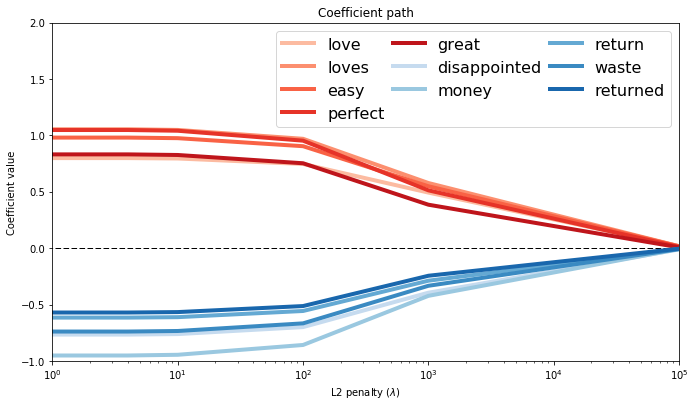

In [68]:
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.filter_by(column_name='word', values=positive_words)
    table_negative_words = table.filter_by(column_name='word', values=negative_words)
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()
    
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

In [72]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    predictions = [+1 if i>0 else -1 for i in scores]
    
    correct_and_wrong = Counter(predictions == sentiment)
    accuracy = float(correct_and_wrong[1])/float(correct_and_wrong[1]+correct_and_wrong[0])
    return accuracy


# Below, we compare the accuracy on the **training data** and **validation data** for all the models that were trained in this assignment.  We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

# In[53]:

train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, l2_coefficeints[0])
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, l2_coefficeints[4])
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, l2_coefficeints[10])
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, l2_coefficeints[100])
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, l2_coefficeints[1000])
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, l2_coefficeints[100000])

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, l2_coefficeints[0])
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, l2_coefficeints[4])
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, l2_coefficeints[10])
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, l2_coefficeints[100])
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, l2_coefficeints[1000])
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, l2_coefficeints[100000])


# In[54]:

# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print "L2 penalty = %g" % key
    print "train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key])
    print "--------------------------------------------------------------------------------"

L2 penalty = 0
train accuracy = 0.785156157787, validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.785179764406, validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.785061731309, validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.784684025401, validation_accuracy = 0.781252917561
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.778853190435, validation_accuracy = 0.774717580058
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.712140884304, validation_accuracy = 0.701241714126
-----------------------------------------------------------------------------